In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update path for Kaggle environment)
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names to remove leading/trailing whitespace
df.columns = df.columns.str.strip()

# Ensure target column exists
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Stratified split: 80% train, 20% test
train_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["Humanitarian_Class"], random_state=42
)

# Save splits to CSV in current working directory
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# Structured summary table
split_summary = pd.DataFrame({
    "Train (80%)": train_df["Humanitarian_Class"].value_counts(),
    "Test (20%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

# Save summary table
split_summary.to_csv("/kaggle/working/split_summary.csv")

# Print result
print("✅ Data split (80/20) completed and saved as CSV files in /kaggle/working.")


✅ Data split (80/20) completed and saved as CSV files in /kaggle/working.


2025-05-03 07:28:17.131392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746257297.153685     149 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746257297.160653     149 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🔍 Extracting ELAMO features...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746257315.281821     149 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/20


I0000 00:00:1746257320.100054     202 service.cc:148] XLA service 0x3cb80900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746257320.100824     202 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746257320.503135     202 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746257323.078167     202 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


204/204 - 9s - 44ms/step - accuracy: 0.5167 - loss: 1.2866 - learning_rate: 0.0010
Epoch 2/20
204/204 - 0s - 2ms/step - accuracy: 0.6665 - loss: 0.9006 - learning_rate: 0.0010
Epoch 3/20
204/204 - 0s - 2ms/step - accuracy: 0.7100 - loss: 0.7939 - learning_rate: 0.0010
Epoch 4/20
204/204 - 0s - 2ms/step - accuracy: 0.7284 - loss: 0.7402 - learning_rate: 0.0010
Epoch 5/20
204/204 - 0s - 2ms/step - accuracy: 0.7490 - loss: 0.6814 - learning_rate: 0.0010
Epoch 6/20
204/204 - 0s - 2ms/step - accuracy: 0.7604 - loss: 0.6490 - learning_rate: 0.0010
Epoch 7/20
204/204 - 0s - 2ms/step - accuracy: 0.7707 - loss: 0.6224 - learning_rate: 0.0010
Epoch 8/20
204/204 - 0s - 2ms/step - accuracy: 0.7783 - loss: 0.5936 - learning_rate: 0.0010
Epoch 9/20
204/204 - 0s - 2ms/step - accuracy: 0.7839 - loss: 0.5783 - learning_rate: 0.0010
Epoch 10/20
204/204 - 0s - 2ms/step - accuracy: 0.7890 - loss: 0.5585 - learning_rate: 0.0010
Epoch 11/20
204/204 - 0s - 2ms/step - accuracy: 0.7966 - loss: 0.5402 - learnin

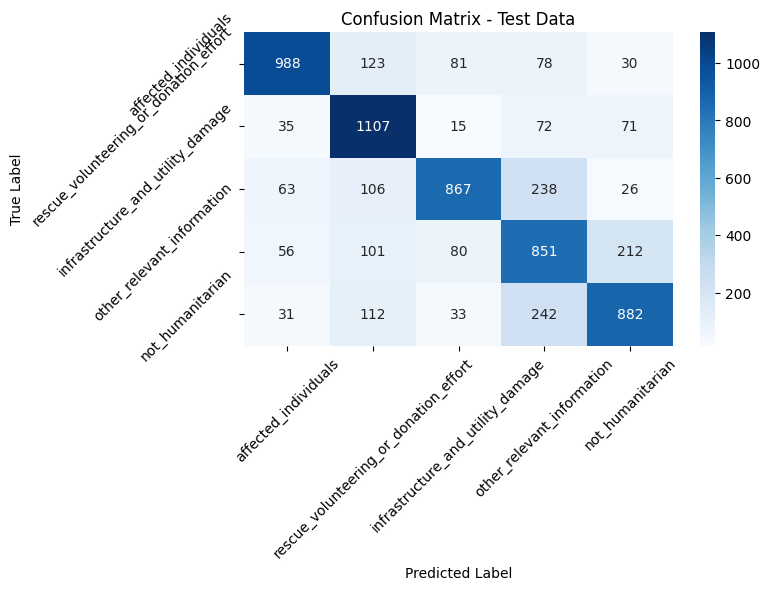

✅ Model saved as 'elamo_humanitarian_cnn_model.h5'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter

# ✅ Load spaCy model
nlp = spacy.load("en_core_web_md")

# 📂 Load Data
train_path = "/kaggle/working/train_data.csv"
test_path = "/kaggle/working/test_data.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 🧹 Normalize column names and preprocess
for df in [train_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()
    df['processed_data'] = df['processed_data'].fillna("")
    df['humanitarian_class'] = df['humanitarian_class'].fillna("not_humanitarian").str.strip().str.lower()

# 🏷️ Label Encoding
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

train_df['label'] = train_df['humanitarian_class'].map(label_map)
test_df['label'] = test_df['humanitarian_class'].map(label_map)

y_train = train_df['label'].values
y_test = test_df['label'].values

# ✨ ELAMO Feature Extraction
def extract_elamo_features(texts):
    lexical_vectors = []
    pos_counts = []
    lemma_counts = []

    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        if doc.has_vector:
            lexical_vectors.append(doc.vector)
        else:
            lexical_vectors.append(np.zeros(nlp.vocab.vectors_length))

        pos_tags = [token.pos_ for token in doc]
        lemmas = [token.lemma_ for token in doc]
        pos_counts.append([len(set(pos_tags))])
        lemma_counts.append([len(set(lemmas))])

    return np.hstack((lexical_vectors, pos_counts, lemma_counts))

print("🔍 Extracting ELAMO features...")
X_train = extract_elamo_features(train_df['processed_data'])
X_test = extract_elamo_features(test_df['processed_data'])

# 🔄 Apply SMOTE to Training Data
max_class_samples = max(Counter(y_train).values())
sampling_strategy = {label: max_class_samples for label in np.unique(y_train)}
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 🧪 Apply SMOTE to Test Data (optional, for balanced evaluation)
max_class_test = max(Counter(y_test).values())
sampling_strategy_test = {label: max_class_test for label in np.unique(y_test)}
X_test_resampled, y_test_resampled = SMOTE(sampling_strategy=sampling_strategy_test, k_neighbors=3, random_state=42).fit_resample(X_test, y_test)

# 📏 Normalize Features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_resampled = scaler.transform(X_test_resampled)

# 🧠 Convert Labels to One-Hot
y_train_cat = to_categorical(y_train_resampled, num_classes=5)
y_test_cat = to_categorical(y_test_resampled, num_classes=5)

# 🧱 CNN Model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ⏳ Callbacks
callbacks = [
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-6)
]

# 🏋️ Train Model (no validation set)
history = model.fit(X_train_resampled, y_train_cat,
                    epochs=20,
                    batch_size=128,
                    callbacks=callbacks,
                    verbose=2)

# 🎯 Evaluate Model
y_pred_probs = model.predict(X_test_resampled)
y_pred = np.argmax(y_pred_probs, axis=1)

# 📈 Accuracy & Report
acc = accuracy_score(y_test_resampled, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")

print("📋 Classification Report:")
print(classification_report(y_test_resampled, y_pred, target_names=label_map.keys()))

# 📊 Confusion Matrix
cm = confusion_matrix(y_test_resampled, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# 💾 Save Model
model.save("elamo_humanitarian_cnn_model.h5")
print("✅ Model saved as 'elamo_humanitarian_cnn_model.h5'")
